In [1]:
!pip install -q -U aicrowd-cli

In [2]:
%load_ext aicrowd.magic

In [3]:
import os

# Please use the absolute for the location of the dataset.
# Or you can use relative path with `os.getcwd() + "test_data/validation.csv"`
AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", "/ds_shared_drive/validation.csv")
#AICROWD_TRAINING_PATH = os.getenv("TRAINING_PATH","/ds_shared_drive/train.csv")
#AICROWD_VALIDATION_PATH = os.getenv("VALIDATION_PATH","/ds_shared_drive/validation_ground_truth.csv")
AICROWD_PREDICTIONS_PATH = os.getenv("PREDICTIONS_PATH", "predictions.csv")
AICROWD_ASSETS_DIR = "assets"
AICROWD_API_KEY ="" # Get your key from https://www.aicrowd.com/participants/me

# Install packages 🗃

Please add all pacakage installations in this section

In [4]:
!pip install numpy pandas lightgbm 

### **Import training data**

In [5]:
import numpy as np
import pandas as pd
import nyaggle
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
NUM_FOLD = 5
SEED = 42
target_col = 'diagnosis'
target_values = ['normal','post_alzheimer','pre_alzheimer']
cat_cols = ['intersection_pos_rel_centre']
unique_cols = ['actual_hour_digit', 'actual_minute_digit']
train = pd.read_csv(AICROWD_DATASET_PATH.replace('validation','train'))
train = train[train[target_col].isin(target_values)].copy().reset_index(drop =True)


## **Find missing values in training dataset**
#### Showing missing value's proportion this dataset has.

In [6]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))
missing_data(train)

row_id number_of_digits missing_digit_1 missing_digit_2  \
Total         0               74              74              74   
Percent     0.0         0.225768        0.225768        0.225768   
Types    object          float64         float64         float64   

        missing_digit_3 missing_digit_4 missing_digit_5 missing_digit_6  \
Total                74              74              74              74   
Percent        0.225768        0.225768        0.225768        0.225768   
Types           float64         float64         float64         float64   

        missing_digit_7 missing_digit_8  ... bottom_area_perc left_area_perc  \
Total                74              74  ...             1559           1559   
Percent        0.225768        0.225768  ...         4.756384       4.756384   
Types           float64         float64  ...          float64        float64   

        right_area_perc hor_count vert_count eleven_ten_error other_error  \
Total              1559         0          0                0           0   
Percent        4.756384       0.0        0.0              0.0         0.0   
Types           float64     int64      int64            int64       int64   

         time_diff centre_dot_detect diagnosis  
Total        10251              9951         0  
Percent  31.274979         30.359703       0.0  
Types      float64           float64    object  

[3 rows x 122 columns]

## **target distribution**
#### The proportion for each class. pre-alzheimer is the least class, which has only 420. The normal class has over 30000. Huge class imbalance!

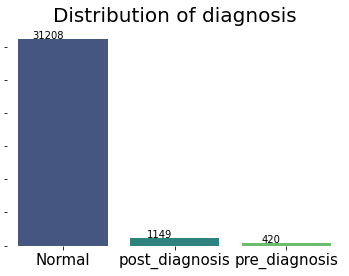

In [7]:
fig, ax = plt.subplots()
g = sns.countplot(train[target_col], palette='viridis')
g.set_xticklabels(['Normal', 'post_diagnosis','pre_diagnosis'])
g.set_yticklabels([])

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 3
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of diagnosis', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

## **feature distribution**
#### Next, I visulize the difference between the class for each numerical features.

<Figure size 432x288 with 0 Axes>

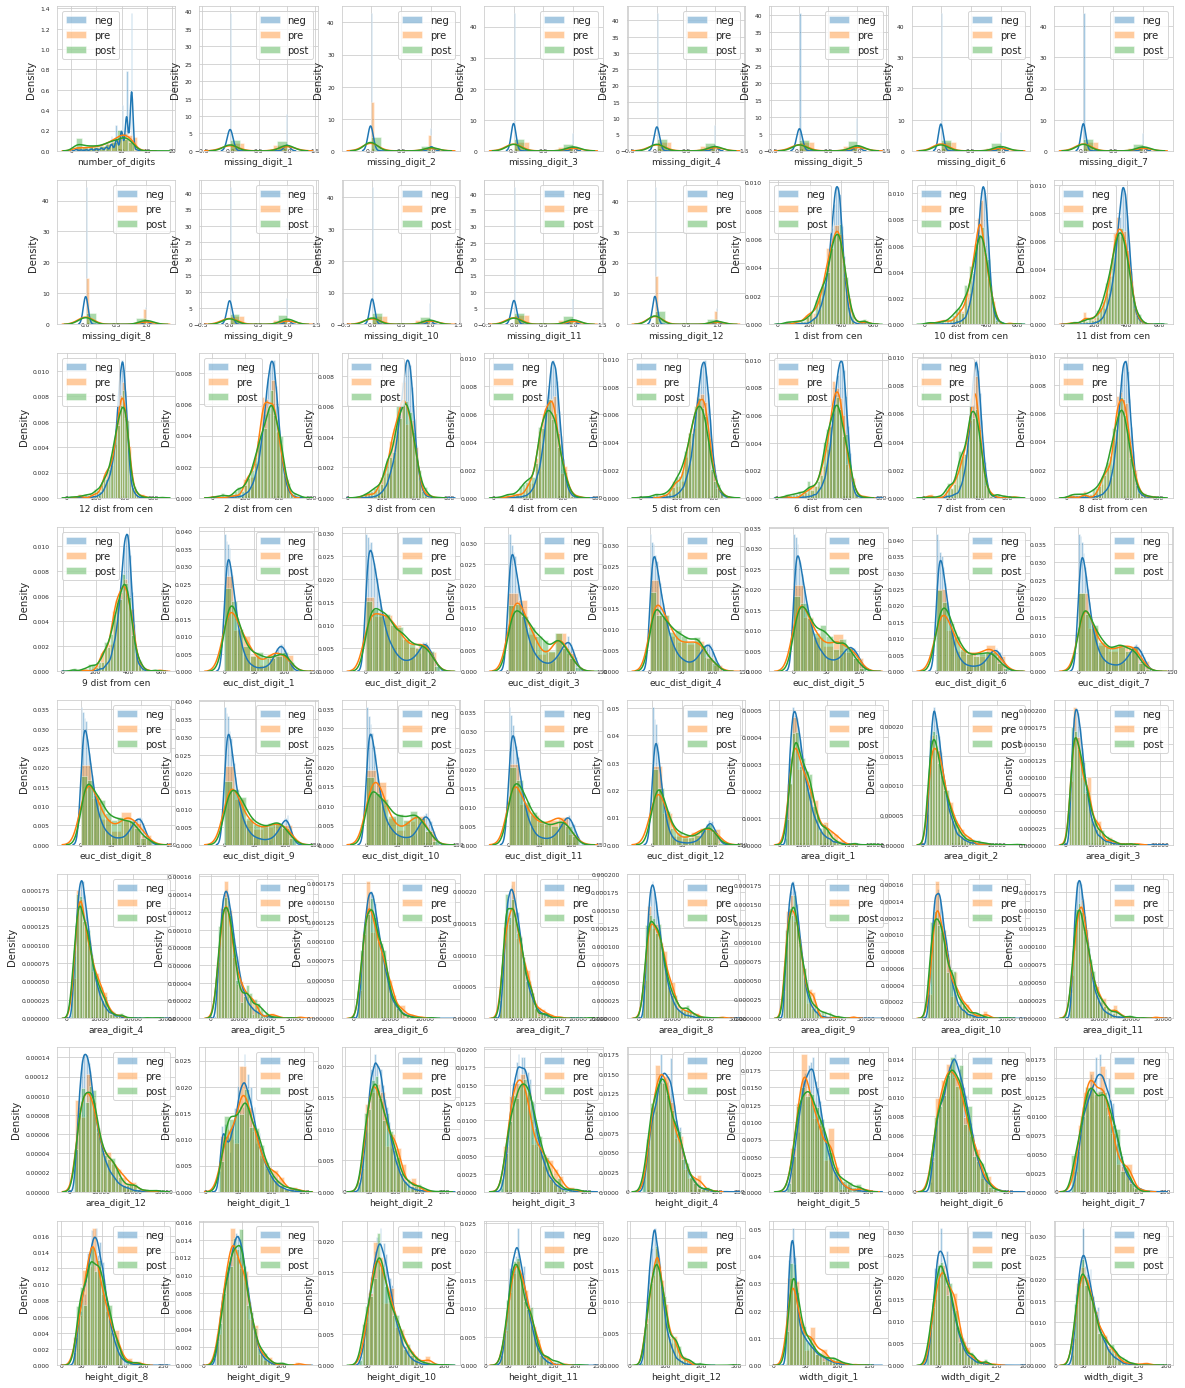

In [8]:
def plot_feature_distribution(df1, df2, df3, label1, label2, label3, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(8,8,figsize=(20,25))

    for feature in features:
        i += 1
        plt.subplot(8,8,i)
        sns.distplot(df1[feature],label=label1)
        sns.distplot(df2[feature],label=label2)
        sns.distplot(df3[feature], label=label3)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
        plt.legend()
    plt.show();

df_post = train[train[target_col] == 'post_alzheimer'].reset_index(drop = True)
df_pre = train[train[target_col] == 'pre_alzheimer'].reset_index(drop = True)
df_neg = train[train[target_col] == 'normal'].reset_index(drop = True)

features = [i for i in train.columns if i not in ['row_id',target_col]+cat_cols]
plot_feature_distribution(df_neg,df_pre,df_post,'neg','pre','post',features[:64])



<Figure size 432x288 with 0 Axes>

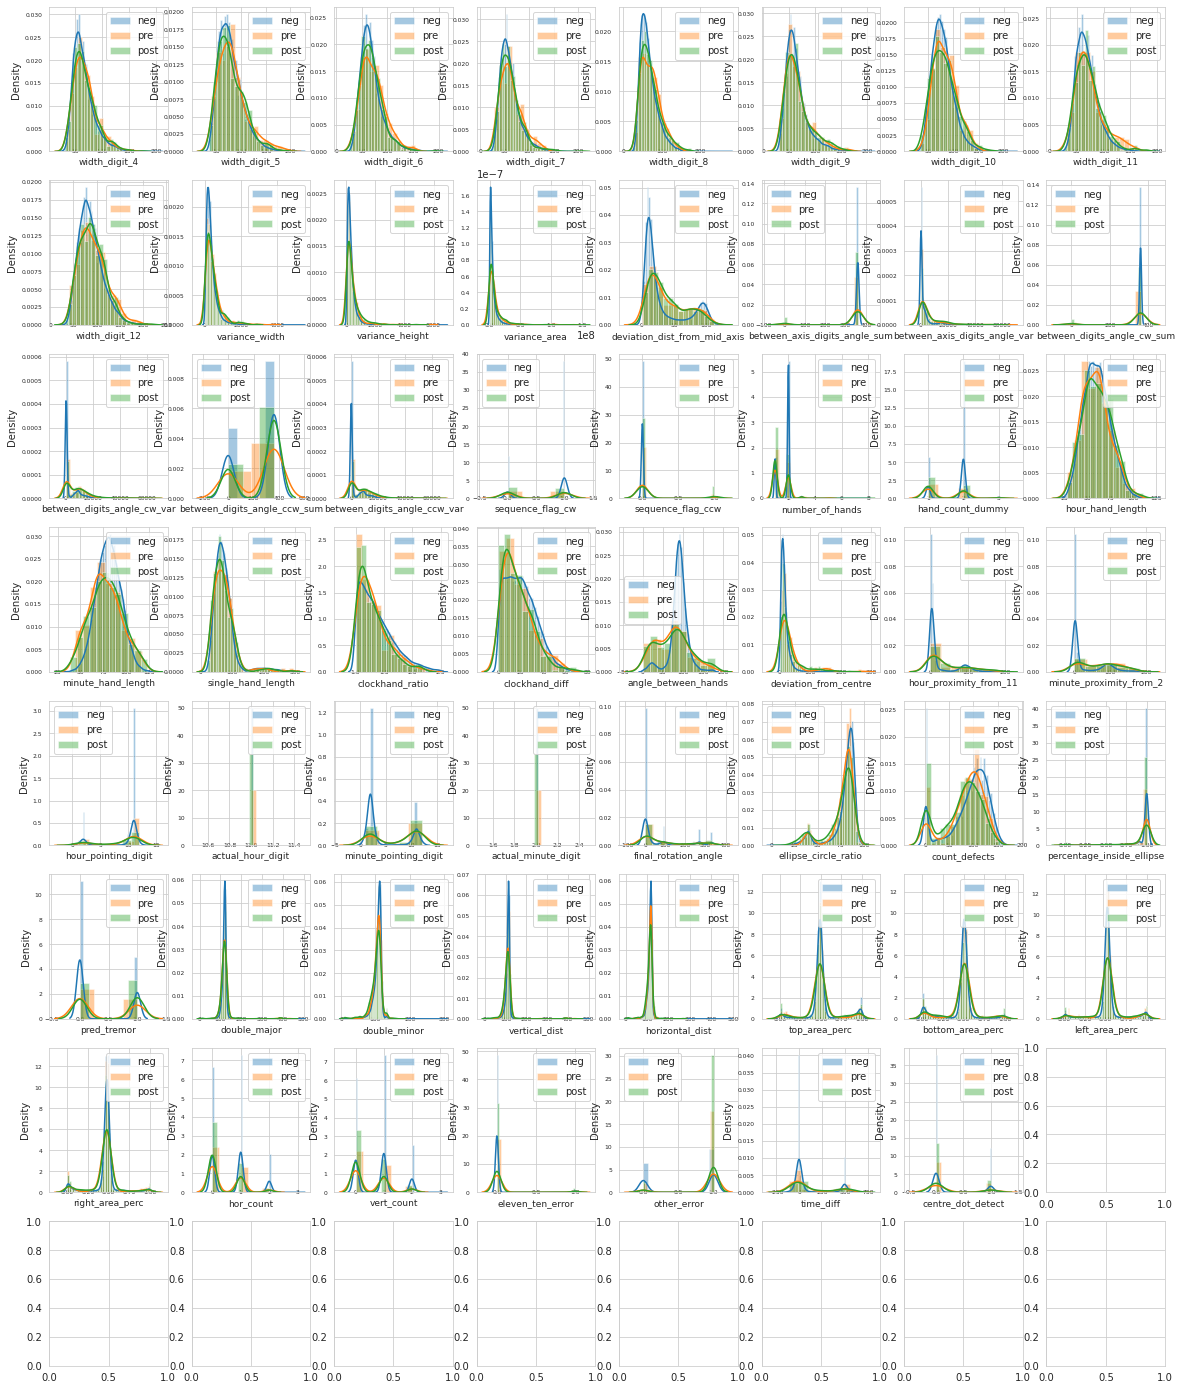

In [9]:
plot_feature_distribution(df_neg,df_pre,df_post,'neg','pre','post',features[64:])

In [10]:
#preprocess
def preprocess(data):
    le = LabelEncoder()
    data[cat_cols] = le.fit_transform(data[cat_cols].fillna('nan'))
    data['num_nan'] = data.isna().sum(axis = 1)
    
    return data
train = preprocess(train)

# training
### To tackle class imbalance, I use undersampling+bagging, and focalloss.
### Focal loss is first published for object detection, but it's also useful in classification.
paper : https://arxiv.org/abs/1708.02002

To apply focal loss in Lightgbm, I referenced [jrzaurin github](https://github.com/jrzaurin/LightGBM-with-Focal-Loss)

In [ ]:
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from scipy import optimize
from scipy import special
from scipy.special import softmax
from scipy.misc import derivative
from sklearn.multiclass import _ConstantPredictor
from sklearn.preprocessing import LabelBinarizer

def focal_loss_lgb(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a,g = alpha, gamma
    y_true = dtrain.label
    # N observations x num_class arrays
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1,num_class, order='F')
    # alpha and gamma multiplicative factors with BCEWithLogitsLoss
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    # flatten in column-major (Fortran-style) order
    return grad.flatten('F'), hess.flatten('F')
def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a,g = alpha, gamma
    y_true = dtrain.label
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1, num_class, order='F')
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    # a variant can be np.sum(loss)/num_class
    return 'focal_loss', np.mean(loss), False



skf = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)
preds = 0.0
focal_loss = lambda x,y: focal_loss_lgb(x, y, 0.25, 1, 3)
eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, 0.25, 1, 3)

params = {'boosting_type': 'gbdt', 'objective': 'multiclass', 'learning_rate': 0.01, 'num_class': 3, 
 'feature_pre_filter': False, 'verbosity': -1, 'lambda_l1': 0.0012642425754982327, 'lambda_l2': 0.01691535659338994, 'num_leaves': 5, 
 'feature_fraction': 0.416, 'bagging_fraction': 0.6851902871453218, 'bagging_freq': 3, 'max_depth':6,
 'min_child_samples': 20, 'num_iterations': 10000, 'early_stopping_round': 100,"bagging_seed" : 2021,"verbosity" : -1 }

df_pos = train[train[target_col].isin(target_values[1:])]
df_neg = train[train[target_col].isin(target_values[:1])]
nb_pos = len(df_pos)
nb_neg = nb_pos*2
nb_total_neg = len(train[train[target_col] == "normal"])
flag = ((df_neg['angle_between_hands']>75) | (df_neg['angle_between_hands']<135)).values
kf = StratifiedKFold(n_splits = nb_total_neg//nb_neg,shuffle = True,random_state=42)

clfs = []
s = []


nsplit = kf.get_n_splits(range(nb_total_neg))
for _,idx in kf.split(range(nb_total_neg),flag):
    df_neg = train[train[target_col] == "normal"].iloc[idx]
    df_samples = pd.concat([df_pos, df_neg]).reset_index(drop=True)
    df_samples = preprocess(df_samples)

    model_features = [c for c in df_samples.columns if c not in ['row_id', target_col]]
    X_train = df_samples[model_features]
    y_train = df_samples[target_col].map(dict(zip(target_values, list(range(len(target_values))))))

    oof = np.zeros((X_train.shape[0],3))
    for fold, (itrain, ivalid) in enumerate(skf.split(X_train, y_train)):
        lgb_train = lgb.Dataset(X_train.iloc[itrain], y_train.iloc[itrain])
        lgb_eval  = lgb.Dataset(X_train.iloc[ivalid], y_train.iloc[ivalid], reference = lgb_train)
        clf = lgb.train(params, lgb_train, 1000, valid_sets=[lgb_eval], fobj=focal_loss, feval=eval_error,
                        early_stopping_rounds=100, verbose_eval=200)
        oof[ivalid] = clf.predict(X_train.iloc[ivalid])
    
        clfs.append(clf)
    s.append(log_loss(y_train,softmax(oof,axis = 1)))


In [12]:
print('-----------------OVERALL SCORE >>> '+str(np.mean(s))+'----------------------------')

-----------------OVERALL SCORE >>> 0.5934543730415751----------------------------


## confution matrix

Normalized confusion matrix
[[9.14e-01 8.57e-02 0.00e+00]
 [4.45e-01 5.54e-01 8.70e-04]
 [6.17e-01 3.83e-01 0.00e+00]]


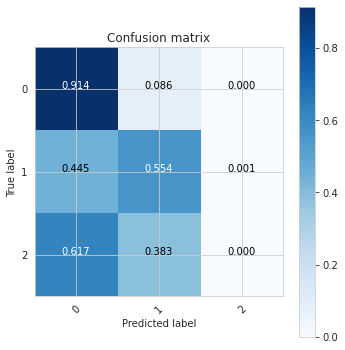

In [14]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

y_pred = oof.argmax(axis = 1)
cm = confusion_matrix(y_train,y_pred)
np.set_printoptions(precision=2)

class_names = np.unique(y_pred).tolist()


plt.figure(figsize=(5,5))
plot_confusion_matrix(
    cm, 
    classes=class_names,
    normalize=True,
    title='Confusion matrix')

#### pre-alzheimer is really difficult to predict.
#### Top score in LB isn't still apropriate for predicting this class. More robust method is needed for better score in LB.
#### Enjoy!!